Target:```As we have already achieved the accuracy numbers within the given constraints i.e, params<10K and epochs <=15.Now lets try to push even further by reducing the number of parms to < 8K and slightly tweaking the start_lr and end_lr for faster convergence```

Result: ```The accuracy crosses 99.4```


Analysis: ```The judgement of understanding the model's capability of performing well was right ,and reducing even more paramaters also could not effect much in achieving the target of 99.4 accuracy here```

# Import Libraries

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
#                                        transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [26]:
class conv_block(nn.Module):
  def __init__(self,in_channels,out_channels,kernel_size=(3,3),dropout=0.1,**kwargs):
    super(conv_block, self).__init__()
    self.convblock = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=kernel_size,**kwargs),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(p=dropout)
        )
    # self.out_channels=out_channels
  def forward(self,x):
    return self.convblock(x)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1=conv_block(in_channels=1,out_channels=10,padding=0)
        self.conv2=conv_block(in_channels=10,out_channels=16,padding=0)
        
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.conv3=conv_block(in_channels=16,out_channels=10,padding=0,kernel_size=(1,1))
        
        self.conv4=conv_block(in_channels=10,out_channels=16,padding=0)
        self.conv5=conv_block(in_channels=16,out_channels=16,padding=0)
        
        self.conv6=conv_block(in_channels=16,out_channels=10,dropout=0.0,padding=0)
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        )
        self.fc1=nn.Linear(10,10)

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        
        x = self.pool1(x)
        x= self.conv3(x)
        x= self.conv4(x)
        x= self.conv5(x)
        x= self.conv6(x)
        x= self.gap(x)
        x = x.view(-1, 10)
        x=self.fc1(x)

#         x=self.conv8(x)
        
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [13]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             120
       BatchNorm2d-2           [-1, 12, 26, 26]              24
              ReLU-3           [-1, 12, 26, 26]               0
           Dropout-4           [-1, 12, 26, 26]               0
        conv_block-5           [-1, 12, 26, 26]               0
            Conv2d-6           [-1, 16, 24, 24]           1,744
       BatchNorm2d-7           [-1, 16, 24, 24]              32
              ReLU-8           [-1, 16, 24, 24]               0
           Dropout-9           [-1, 16, 24, 24]               0
       conv_block-10           [-1, 16, 24, 24]               0
        MaxPool2d-11           [-1, 16, 12, 12]               0
           Conv2d-12           [-1, 10, 12, 12]             170
      BatchNorm2d-13           [-1, 10, 12, 12]              20
             ReLU-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [14]:
from tqdm import tqdm_notebook,tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []


def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader,position=0)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)
    # print(data.shape)
    # Init
    # scheduler.step()
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    # scheduler.step()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    # print(f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [25]:
from torch.optim.lr_scheduler import StepLR,LambdaLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
start=0.2
end=0.001
EPOCHS = 15

diff=(start-end)/EPOCHS
li=[start-(i*diff) for i in range(1,EPOCHS+1)]

def get_lr(epoch):
    return li[epoch]
    

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    optimizer.param_groups[0]["lr"]=get_lr(epoch)
    print(optimizer.param_groups[0]["lr"])
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.1903165727853775 Batch_id=468 Accuracy=89.88: 100%|██████████| 469/469 [00:10<00:00, 42.98it/s]  

0.18673333333333333



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0563, Accuracy: 9815/10000 (98.15%)

EPOCH: 1


Loss=0.0909738764166832 Batch_id=468 Accuracy=96.55: 100%|██████████| 469/469 [00:35<00:00, 13.18it/s]  

0.17346666666666669



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0606, Accuracy: 9804/10000 (98.04%)

EPOCH: 2


Loss=0.06994500011205673 Batch_id=468 Accuracy=97.37: 100%|██████████| 469/469 [00:35<00:00, 13.23it/s] 

0.1602



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0375, Accuracy: 9872/10000 (98.72%)

EPOCH: 3


Loss=0.051775503903627396 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:36<00:00, 12.91it/s] 

0.14693333333333333



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0370, Accuracy: 9881/10000 (98.81%)

EPOCH: 4


Loss=0.04476571083068848 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:34<00:00, 13.40it/s]  

0.13366666666666666



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0361, Accuracy: 9875/10000 (98.75%)

EPOCH: 5


Loss=0.049550652503967285 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:35<00:00, 13.40it/s]

0.12040000000000001



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9925/10000 (99.25%)

EPOCH: 6


Loss=0.01569470763206482 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:34<00:00, 13.43it/s] 

0.10713333333333333



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9917/10000 (99.17%)

EPOCH: 7


Loss=0.03835498169064522 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:34<00:00, 13.43it/s]  

0.09386666666666667



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9928/10000 (99.28%)

EPOCH: 8


Loss=0.03236857429146767 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:34<00:00, 13.43it/s]  

0.0806



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9910/10000 (99.10%)

EPOCH: 9


Loss=0.08275085687637329 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:34<00:00, 13.42it/s]  

0.06733333333333333



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9921/10000 (99.21%)

EPOCH: 10


Loss=0.12014270573854446 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:34<00:00, 13.43it/s]  

0.05406666666666665



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9931/10000 (99.31%)

EPOCH: 11


Loss=0.11176391690969467 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:35<00:00, 13.36it/s]  

0.0408



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9928/10000 (99.28%)

EPOCH: 12


Loss=0.03565574809908867 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:35<00:00, 13.40it/s]  

0.027533333333333326



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9935/10000 (99.35%)

EPOCH: 13


Loss=0.11842451244592667 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:34<00:00, 13.42it/s]  

0.01426666666666665



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9937/10000 (99.37%)

EPOCH: 14


Loss=0.031506359577178955 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:34<00:00, 13.42it/s] 

0.0010000000000000009



Test set: Average loss: 0.0183, Accuracy: 9942/10000 (99.42%)



# Let's Train and test our model

This time let's add a scheduler for out LR. 

Text(0.5, 1.0, 'Test Accuracy')

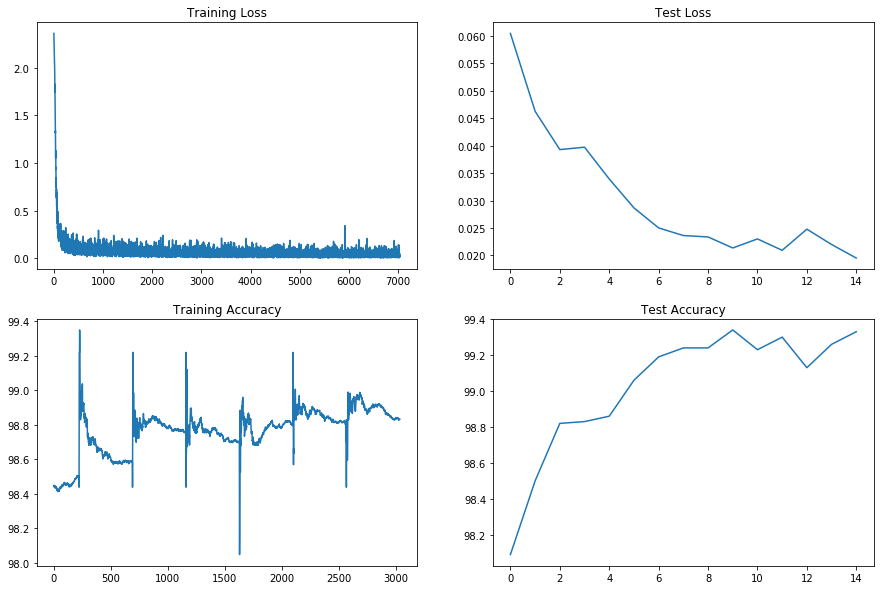

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Miclassification Analysis

In [19]:
def find_misclassified(model, device, test_loader):
    model.eval()
    test_loss = 0
    misclassified=[]
    correct = 0
    actual=[]
    pred=[]
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            out=torch.argmax(output,axis=1)
            temp=[target.ne(out)]
            
            misclassified.extend(data[temp])
            actual.extend(target[temp])
            pred.extend(out[temp])
            
    return misclassified,actual,pred

In [20]:
mis,actual,pred=find_misclassified(model,device,test_loader)

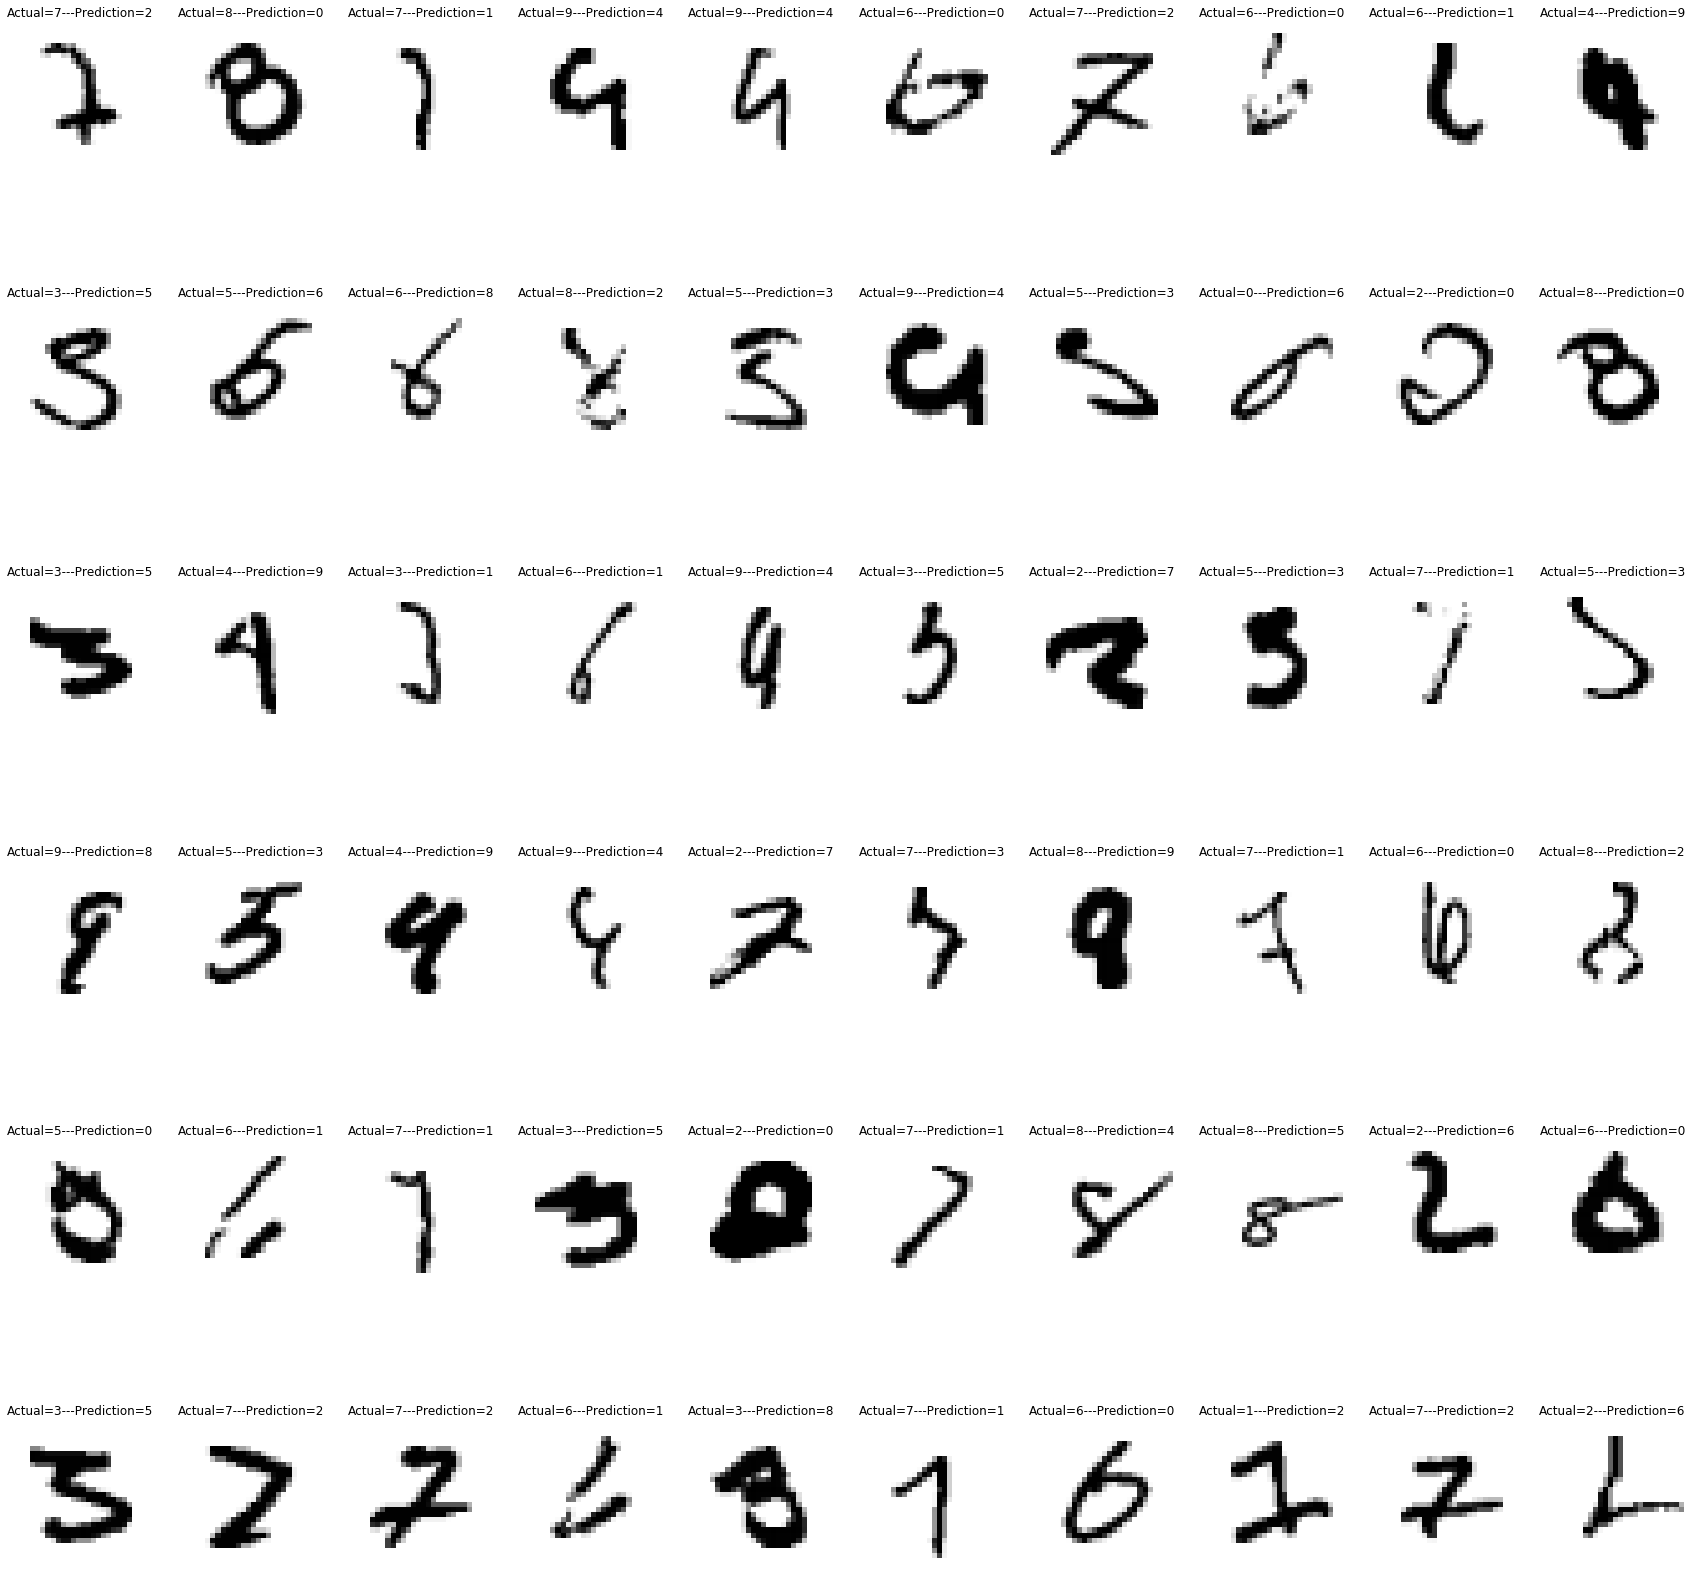

In [21]:
figure = plt.figure(figsize=(30,30))
num_of_images = 60
for index in range(0, num_of_images ):
    plt.subplot(6, 10, index+1)
    plt.axis('off')
    plt.title(f"Actual={actual[index]}---Prediction={pred[index]}")
    plt.imshow(mis[index].cpu().numpy().squeeze(), cmap='gray_r')